In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.6 MB/s 


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.5 MB/s 


In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.7 MB/s 
     |████████████████████████████████| 133 kB 9.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=95088e9a56a55f996f5826bdf984c886eac7cf0f1961c2221d7751dce3ad6631
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incom

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
import eli5
from eli5.sklearn import PermutationImportance
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
import numpy as np
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
file_uploaded = files.upload()

Saving main.csv to main.csv


In [ ]:
df = pd.read_csv('main.csv')
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1609459200000,28923.63,28961.66,28913.12,28961.66,27.457032,1609459259999,7.943820e+05,1292,16.777195,485390.826825
1,1609459260000,28961.67,29017.50,28961.01,29009.91,58.477501,1609459319999,1.695803e+06,1651,33.733818,978176.468202
2,1609459320000,29009.54,29016.71,28973.58,28989.30,42.470329,1609459379999,1.231359e+06,986,13.247444,384076.854453
3,1609459380000,28989.68,28999.85,28972.33,28982.69,30.360677,1609459439999,8.800168e+05,959,9.456028,274083.075142
4,1609459440000,28982.67,28995.93,28971.80,28975.65,24.124339,1609459499999,6.992262e+05,726,6.814644,197519.374888


In [ ]:
print(' size :', df.shape, '\n\n', 
      'duplicated :', df.duplicated().sum(), '\n\n', 
      df.isnull().sum()
      )

 size : (188317, 11) 

 duplicated : 0 

 Open Time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close Time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
dtype: int64


In [ ]:
df1 = df.copy()

In [ ]:
df0 = df.copy()

In [ ]:
df0['up & down'] = (df['Close'] - df['Open']) > 0
df0.drop(['Open Time','Close Time'], axis = 1, inplace = True)

In [ ]:
df0.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,up & down
0,28923.63,28961.66,28913.12,28961.66,27.457032,7.943820e+05,1292,16.777195,485390.826825,True
1,28961.67,29017.50,28961.01,29009.91,58.477501,1.695803e+06,1651,33.733818,978176.468202,True
2,29009.54,29016.71,28973.58,28989.30,42.470329,1.231359e+06,986,13.247444,384076.854453,False
3,28989.68,28999.85,28972.33,28982.69,30.360677,8.800168e+05,959,9.456028,274083.075142,False
4,28982.67,28995.93,28971.80,28975.65,24.124339,6.992262e+05,726,6.814644,197519.374888,False


In [ ]:
target = 'up & down'

train_0 = df0.iloc[50:112990,:]
val_0 = df0.iloc[112991:150653,:]
test_0 = df0.iloc[150654:,:]

X_train_0 = train_0.iloc[:,:-1]
X_val_0 = val_0.iloc[:,:-1]
X_test_0 = test_0.iloc[:,:-1]

y_train_0 = train_0[target]
y_val_0 = val_0[target]
y_test_0 = test_0[target]

In [ ]:
train_lgb_0 = lightgbm.Dataset(X_train_0, label = y_train_0)
val_lgb_0 = lightgbm.Dataset(X_val_0, label = y_val_0)
test_lgb_0 = lightgbm.Dataset(X_test_0, label = y_test_0) 

In [ ]:
lgb_clf_0 = lightgbm.LGBMClassifier(num_leaves=31, objective='binary', random_state = 11)
lgb_clf_0.fit(X_train_0, y_train_0)
y_pred_0 = lgb_clf_0.predict(X_val_0)

In [ ]:
print(
      ' accuracy score :', accuracy_score(y_val_0, y_pred_0),'\n\n',
      '      f1 score :',f1_score(y_val_0, y_pred_0) 
     )

 accuracy score : 0.6619669693590357 

       f1 score : 0.6683512647510875


In [ ]:
df1['MA10'] = df1['Close'].rolling(10).mean()

std = df1['Close'].rolling(10).std()
df1['upperbollinger'] = df1['MA10'] + (std *2)
df1['lowerbollinger'] = df1['MA10'] - (std *2)
df1['buy'] = df1['Close'] < df1['lowerbollinger']
df1['sell'] = df1['Close'] > df1['upperbollinger']


df1['shift'] = df1['Close'] - df1['Close'].shift(1)
df1['upsize'] = np.where(df1['shift']>=0, df1['shift'], 0)
df1['downsize'] = np.where(df1['shift'] <0, df1['shift'].abs(), 0)
# welles moving average
df1['AU'] = df1['upsize'].ewm(alpha=1/5, min_periods=5).mean()
df1['AD'] = df1['downsize'].ewm(alpha=1/5, min_periods=5).mean()
#df['RS'] = df['AU'] / df['AD']
#df['RSI'] = 100 - (100 / (1 + df['RS']))
df1['RSI'] = df1['AU'] / (df1['AU'] + df1['AD']) * 100

df1['up & down'] = (df['Close'] - df['Open']) > 0
df1.drop(['Open Time','Close Time','shift','upsize','downsize','AU','AD','upperbollinger','lowerbollinger'], axis = 1, inplace = True)

In [ ]:
df1.head(50)

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,MA10,buy,sell,RSI,up & down
0,28923.63,28961.66,28913.12,28961.66,27.457032,7.943820e+05,1292,16.777195,4.853908e+05,NaN,False,False,NaN,True
1,28961.67,29017.50,28961.01,29009.91,58.477501,1.695803e+06,1651,33.733818,9.781765e+05,NaN,False,False,NaN,True
2,29009.54,29016.71,28973.58,28989.30,42.470329,1.231359e+06,986,13.247444,3.840769e+05,NaN,False,False,NaN,False
3,28989.68,28999.85,28972.33,28982.69,30.360677,8.800168e+05,959,9.456028,2.740831e+05,NaN,False,False,NaN,False
4,28982.67,28995.93,28971.80,28975.65,24.124339,6.992262e+05,726,6.814644,1.975194e+05,NaN,False,False,49.189206,False
5,28975.65,28979.53,28933.16,28937.11,22.396014,6.483227e+05,952,9.127550,2.642179e+05,NaN,False,False,25.106354,False
6,28937.11,28963.25,28937.10,28943.87,20.480294,5.929263e+05,750,5.444172,1.576094e+05,NaN,False,False,32.366494,True
7,28943.88,28954.48,28930.00,28934.84,20.962343,6.065811e+05,782,13.154737,3.806512e+05,NaN,False,False,27.857379,False
8,28934.84,28936.15,28889.24,28900.00,52.645478,1.521739e+06,886,28.440008,8.218062e+05,NaN,False,False,16.662240,False
9,28900.00,28920.06,28846.28,28858.94,98.083975,2.831962e+06,1558,57.594864,1.662928e+06,28949.397,True,False,10.466067,False


In [ ]:
df1['up & down'].value_counts(normalize = True)

False    0.501744
True     0.498256
Name: up & down, dtype: float64

In [ ]:
train_len = int(len(df1)*0.6)
val_test_ratio = int(len(df1)*0.2)
val_len = train_len + val_test_ratio
print(train_len, val_len)

112990 150653


In [ ]:
target = 'up & down'

train = df1.iloc[50:112990,:]
val = df1.iloc[112991:150653,:]
test = df1.iloc[150654:,:]

X_train = train.iloc[:,:-1]
X_val = val.iloc[:,:-1]
X_test = test.iloc[:,:-1]

y_train = train[target]
y_val = val[target]
y_test = test[target]

print(' train :', train.shape, '\n\n',
      'val :', val.shape, '\n\n',
      'test :', test.shape, '\n\n',
      'X_train :',X_train.shape, '\n\n',
      'X_val :', X_val.shape, '\n\n',
      'X_test :', X_test.shape, '\n\n',
      'y_train :', y_train.shape, '\n\n',
      'y_val :', y_val.shape, '\n\n',
      'y_test :', y_test.shape
      )

 train : (112940, 14) 

 val : (37662, 14) 

 test : (37663, 14) 

 X_train : (112940, 13) 

 X_val : (37662, 13) 

 X_test : (37663, 13) 

 y_train : (112940,) 

 y_val : (37662,) 

 y_test : (37663,)


In [ ]:
train_lgb = lightgbm.Dataset(X_train, label = y_train)
val_lgb = lightgbm.Dataset(X_val, label = y_val)
test_lgb = lightgbm.Dataset(X_test, label = y_test) 

In [ ]:
lgb_clf = lightgbm.LGBMClassifier(objective='binary', random_state = 11)

tscv = TimeSeriesSplit(n_splits = 5)

param = {
    'n_estimators':[180,200],
    'max_depth':[9,25,30],
    'num_leaves':[25,31,45],
    'min_child_samples':[380,400,420]   
}

grid_lgb = GridSearchCV(lgb_clf,                        # 모델 객체
                  param_grid = param,     # 하이퍼파라미터 목록
                  scoring = 'accuracy',
                  cv = tscv,
                  n_jobs = -1
                                   
                  )


grid_lgb.fit(X_train, y_train)

bestgrid = grid_lgb.best_estimator_
bestgridpred = bestgrid.predict(X_val)


print("최적 파라미터 : ", grid_lgb.best_params_, '\n\n',
      'best score :', grid_lgb.best_score_, '\n\n',
      'best f1 :', f1_score(y_val, bestgridpred)
      )

최적 파라미터 :  {'max_depth': 30, 'min_child_samples': 400, 'n_estimators': 200, 'num_leaves': 45} 

 best score : 0.7597832439037348 

 best f1 : 0.7465951628746649


In [ ]:
print("최적 파라미터 : ", grid_lgb.best_params_, '\n\n',
      'accuracy score :', grid_lgb.best_score_, '\n\n',
      '      f1 score :', f1_score(y_val, bestgridpred)
      )

최적 파라미터 :  {'max_depth': 30, 'min_child_samples': 400, 'n_estimators': 200, 'num_leaves': 45} 

 accuracy score : 0.7597832439037348 

       f1 score : 0.7465951628746649


In [ ]:
bestgrid = grid_lgb.best_estimator_
bestgridpred = bestgrid.predict(X_val)
bestgirdproba = bestgrid.predict_proba(X_val)[:,1]

In [ ]:
grid_fprs, grid_tprs, grid_thresholds = roc_curve(y_val, bestgirdproba)

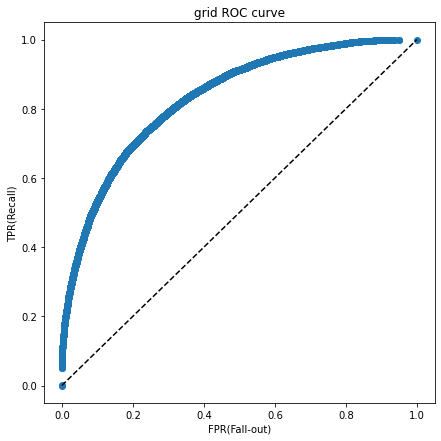

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(grid_fprs, grid_tprs)
plt.plot((0,1), (0,1), linestyle = '--', color  = 'black')
plt.title('grid ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
print(roc_auc_score(y_val, bestgrid.predict_proba(X_val)[:,1])) # 범위는 0-1, 수치는 높을 수록 좋습니다

0.8321662855897277


In [ ]:
# permuter 정의
permuter = PermutationImportance(
    bestgrid, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=11
)


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val, y_val);

In [ ]:
feature_names = X_val.columns.tolist()

In [ ]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1449 ± 0.0023,RSI
0.0747 ± 0.0033,Open
0.0493 ± 0.0017,MA10
0.0447 ± 0.0011,Taker buy base asset volume
0.0372 ± 0.0029,Close
0.0274 ± 0.0027,Volume
0.0260 ± 0.0016,Taker buy quote asset volume
0.0143 ± 0.0013,Quote asset volume
0.0071 ± 0.0007,buy
0.0061 ± 0.0009,sell


In [ ]:
bestgrid.fit(X_test, y_test)
test_pred = bestgrid.predict(X_test)

In [ ]:
print('test accuracy score :', accuracy_score(y_test, test_pred), '\n\n',
      '     test f1 score :', f1_score(y_test, test_pred)
      )

test accuracy score : 0.8692881607944136 

      test f1 score : 0.868463943142651


In [ ]:
print(roc_auc_score(y_test, bestgrid.predict_proba(X_test)[:,1])) # 범위는 0-1, 수치는 높을 수록 좋습니다

0.9478303132086028


In [ ]:
df2 = X_test.copy()

In [ ]:
df2['proba'] =  bestgrid.predict_proba(X_test)[:,1]

In [ ]:
df2.sort_values(by = 'proba', ascending=False, inplace = True)

In [ ]:
df2.reset_index(drop=True, inplace=True)

In [ ]:
explainer = shap.TreeExplainer(bestgrid)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][10000,:], X_test.columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5000:5500,:], X_test.columns)

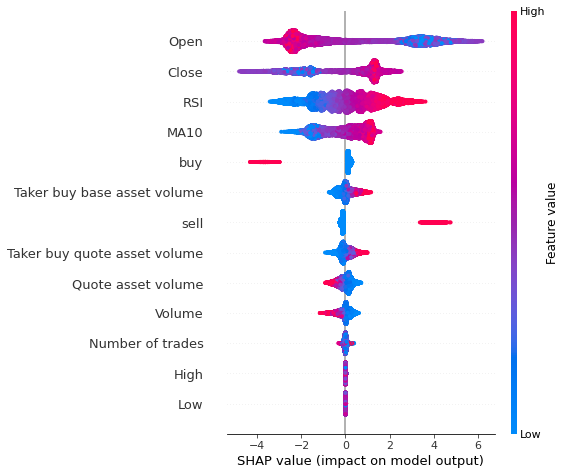

In [ ]:
shap.summary_plot(shap_values[1], X_test)

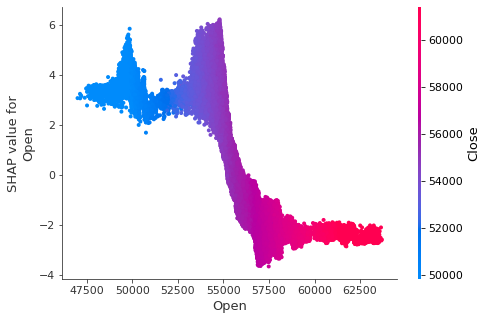

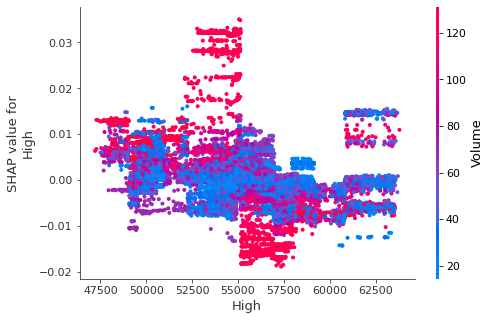

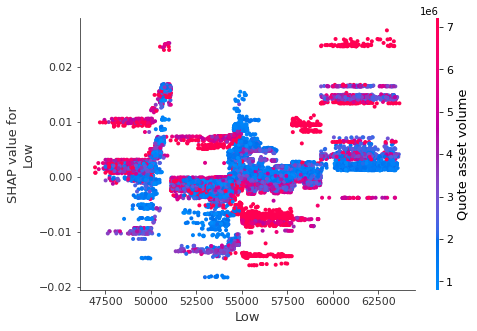

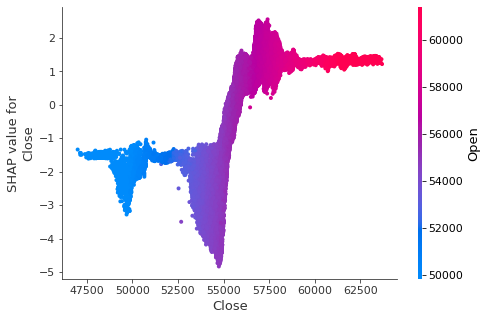

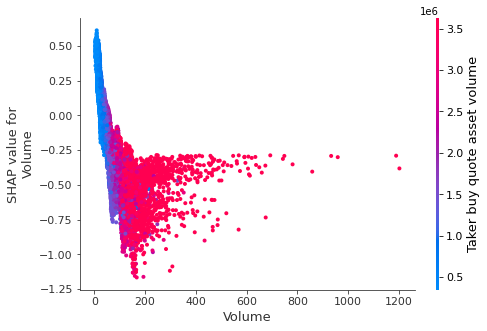

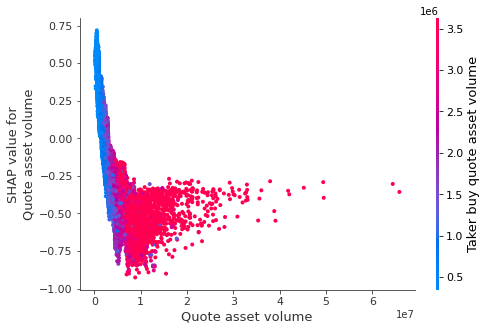

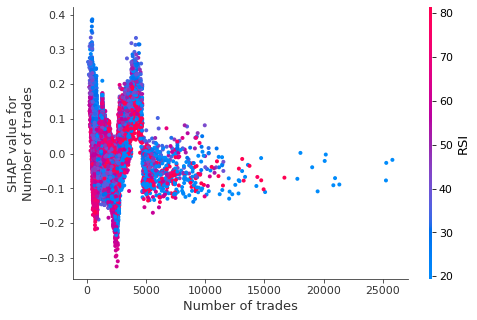

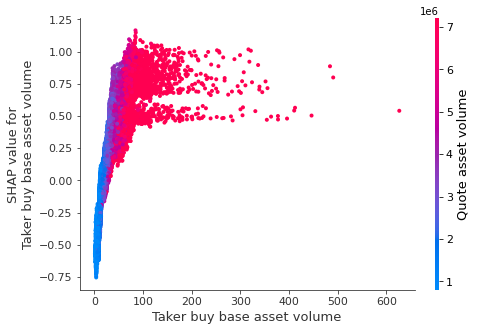

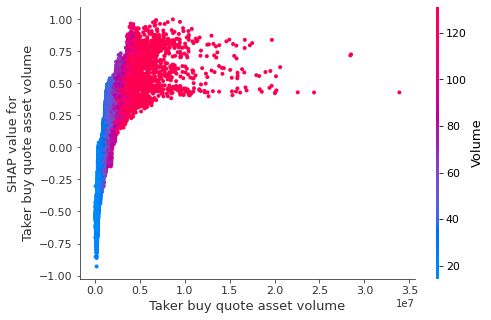

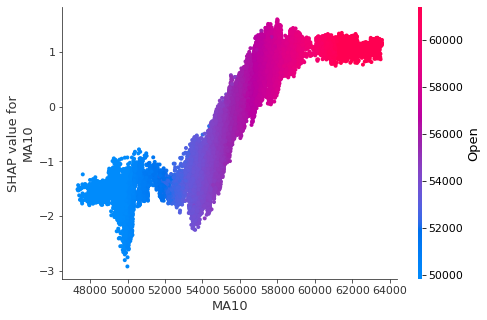

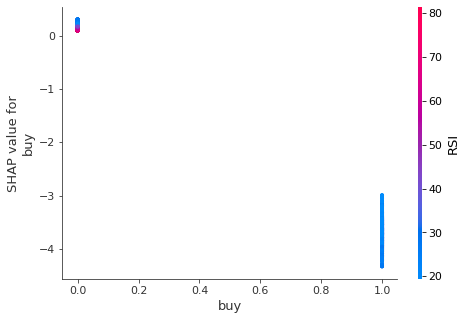

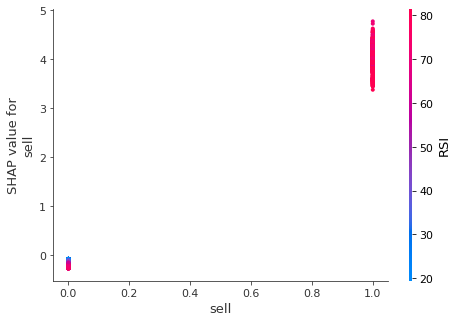

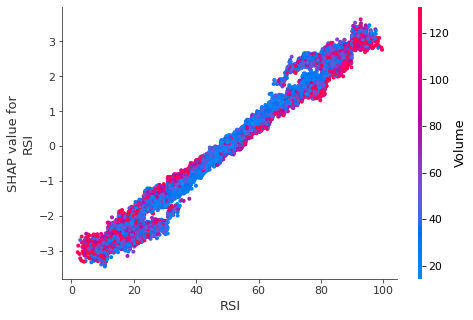

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_test, display_features=X_test)